Instalar librerías

In [1]:
!pip install scikit-learn --upgrade --user

Requirement already up-to-date: scikit-learn in c:\users\ivan martinez\appdata\roaming\python\python37\site-packages (0.23.2)


In [2]:
!pip install xgboost --upgrade --upgrade

Requirement already up-to-date: xgboost in c:\programdata\anaconda3\lib\site-packages (1.2.1)


In [3]:
!pip install imblearn --upgrade --upgrade

Requirement already up-to-date: imblearn in c:\programdata\anaconda3\lib\site-packages (0.0)


Importar librerías

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Leyendo la imagen fuente

In [5]:
im = cv2.imread("IMG_3622.jpeg")
num_rows = im.shape[0]
num_cols = im.shape[1]

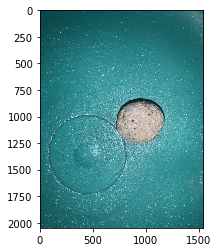

In [6]:
im_corrected = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_corrected)

Datos de entrenamiento

In [7]:
R=[]
G=[]
B=[]
target=[]

    #Datos de recipiente, target=0, primeras 100 columnas y 1800 filas
for i in range (100):
    for j in range (1800):
        r=int(np.array(im[j][i][2]))
        R.append(r)
        g=int(np.array(im[j][i][1]))
        G.append(g)
        b=int(np.array(im[j][i][0]))
        B.append(b)
        target.append(0)
        # Datos de roca, target=1, fila 900, columna 800 hasta fila 1200, columna 1050
for i in range (800,1050,1):
    for j in range (900,1200,1):
        r=int(np.array(im[j][i][2]))
        R.append(r)
        g=int(np.array(im[j][i][1]))
        G.append(g)
        b=int(np.array(im[j][i][0]))
        B.append(b)
        target.append(1)
df_train=pd.DataFrame(R,columns=["RED"])
df_train["GREEN"]=G
df_train["BLUE"]=B
df_train["target"]=target
print(df_train)
df_train.to_csv('FondoBlanco_train.csv',index=True)

        RED  GREEN  BLUE  target
0        10     70    70       0
1        11     71    71       0
2        13     73    73       0
3        13     73    73       0
4        10     70    70       0
...     ...    ...   ...     ...
254995  209    196   187       1
254996  205    195   185       1
254997  189    179   170       1
254998  173    163   154       1
254999  142    131   125       1

[255000 rows x 4 columns]


Los valores de entrenamiento son los que se muestran encerrados en la imagen a continuación:

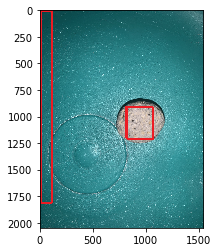

In [26]:
im_recuadro = np.ones((num_rows, num_cols, 3), dtype=np.uint8)
for r in range(num_rows):
    for c in range(num_cols):
            im_recuadro[r, c, :] = im[r][c]

#Recuadro de recipiente
for j in range (0,20,1):
    for i in range (100+j):
        im_recuadro[0+j][i]=[36,28,237]
        im_recuadro[1800+j][i]=[36,28,237]
    for i in range (1800+j):
        im_recuadro[i][0+j]=[36,28,237]
        im_recuadro[i][100+j]=[36,28,237]

#Recuadro roca
for j in range (0,20,1):
    for i in range (800+j,1050+j,1):
        im_recuadro[900+j][i]=[36,28,237]
        im_recuadro[1200+j][i]=[36,28,237]
    for i in range (900+j,1200+j,1):
        im_recuadro[i][800+j]=[36,28,237]
        im_recuadro[i][1050+j]=[36,28,237]


cv2.imwrite("im_recuadro.png", im_recuadro)
im_rec_corrected = cv2.cvtColor(im_recuadro, cv2.COLOR_BGR2RGB)
plt.imshow(im_rec_corrected)

Seleccionando las columnas "features" y "target"

In [9]:
features = df_train[
    [        
        'RED', 
        'GREEN', 
        'BLUE'        
    ]
]

target = df_train['target']  ## NO CAMBIE EL NOMBRE DE LA VARIABLE "target".

Dividiendo el conjunto de datos para una "prueba ciega"

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=380)

Entrenando un árbol de decisión

In [11]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)

Haciendo la predicción en la muestra de prueba

In [12]:
y_pred=dtc.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


Analizando la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.9999\nPrecision=0.9999\nRecall=0.9997\nF1 Score=0.9998336604677468')

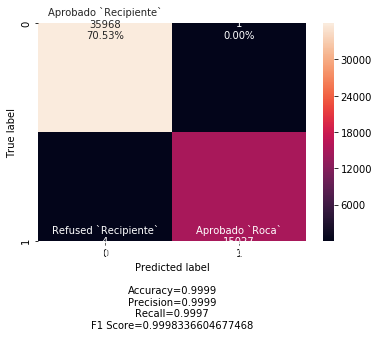

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Recipiente`', 'Refused `Roca`', 'Refused `Recipiente`', 'Aprobado `Roca`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.4f}\nPrecision={:0.4f}\nRecall={:0.4f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [14]:
from sklearn.metrics import accuracy_score

# Precisión lograda por el árbol de decisiones
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Exactitud: 99.99%


Datos de evaluación

In [15]:
RT=[]
GT=[]
BT=[]

for i in range (num_cols):
    for j in range (num_rows):
        rt=int(np.array(im[j][i][2]))
        RT.append(rt)
        gt=int(np.array(im[j][i][1]))
        GT.append(gt)
        bt=int(np.array(im[j][i][0]))
        BT.append(bt)

df_test=pd.DataFrame(RT,columns=["RED"])
df_test["GREEN"]=GT
df_test["BLUE"]=BT
print(df_test)

         RED  GREEN  BLUE
0         10     70    70
1         11     71    71
2         13     73    73
3         13     73    73
4         10     70    70
...      ...    ...   ...
3145723   22     92    94
3145724   20     92    91
3145725   19     91    90
3145726   19     91    90
3145727   21     93    92

[3145728 rows x 3 columns]


Hacer las predicciones

In [16]:
y_pred = dtc.predict(df_test)
df_test['target'] = y_pred
print(df_test.tail())

         RED  GREEN  BLUE  target
3145723   22     92    94       0
3145724   20     92    91       0
3145725   19     91    90       0
3145726   19     91    90       0
3145727   21     93    92       0


Guardando resulados en archivo csv

In [17]:
df_test.to_csv('FondoBlanco_test.csv',index=True)

Creando la imagen con fondo blanco

In [18]:
compressed_image = np.ones((num_rows, num_cols, 3), dtype=np.uint8)
for r in range(num_rows):
    for c in range(num_cols):
        compressed_image[r, c, :] = 255,255,255
#Colocando colores de la roca
        if y_pred[int(c*num_rows+r)]==1:
            compressed_image[r, c, :] = im[r][c]
        
cv2.imwrite("fondoblanco.png", compressed_image)

True

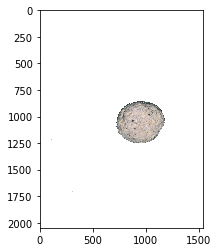

In [19]:
imcomp_corrected = cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB)
plt.imshow(imcomp_corrected)

Borrando valores=0, o sea de recipiente y creando nueva matriz

In [20]:
df_roca=df_test
df_roca = df_roca.drop(df_roca[df_roca['target']==0].index)
df_roca.to_csv('Colores_roca.csv',index=True)
print(df_roca)

         RED  GREEN  BLUE  target
175375   172    191   195       1
218299   165    184   188       1
218301   158    173   176       1
218302   169    184   187       1
218303   173    188   193       1
...      ...    ...   ...     ...
2899817  179    203   203       1
2901865  178    204   205       1
2996400  170    210   210       1
2998449  170    209   208       1
3000496  170    210   209       1

[140167 rows x 4 columns]


Reseteando el índice del dataframe

In [21]:
df_roca = df_roca.reset_index(drop=True)
print(df_roca)

        RED  GREEN  BLUE  target
0       172    191   195       1
1       165    184   188       1
2       158    173   176       1
3       169    184   187       1
4       173    188   193       1
...     ...    ...   ...     ...
140162  179    203   203       1
140163  178    204   205       1
140164  170    210   210       1
140165  170    209   208       1
140166  170    210   209       1

[140167 rows x 4 columns]


Visualizar el conjunto de datos de Rojo, Verde, Azul (valores en porcentajes)

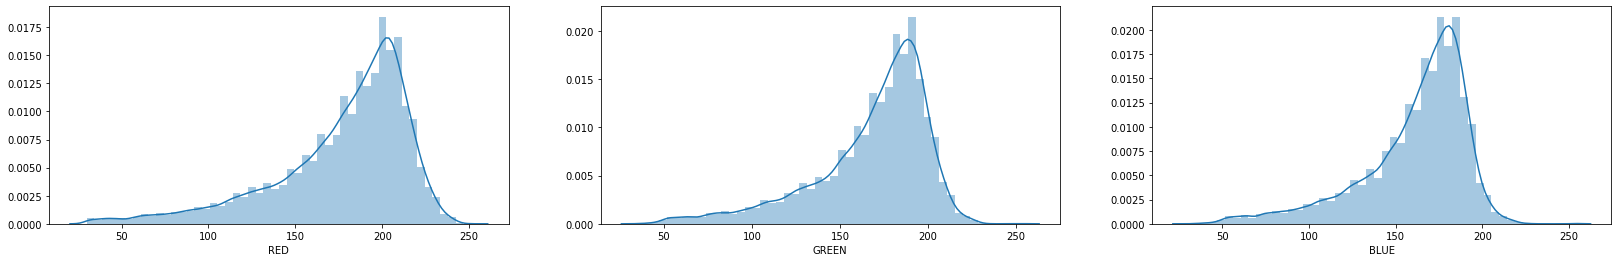

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

import seaborn as sns

sns.distplot(df_roca['RED'].dropna(), ax=axes[0])
sns.distplot(df_roca['GREEN'].dropna(), ax=axes[1])
sns.distplot(df_roca['BLUE'].dropna(), ax=axes[2])

El valor promedio RGB es el siguiente:

In [23]:
df_roca.mean()

RED       177.244737
GREEN     168.063917
BLUE      161.143336
target      1.000000
dtype: float64